# ConvNeXt-V2

## Load ImageNet-100 from hugging face

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from datasets import load_dataset
dataset = load_dataset("clane9/imagenet-100")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.87k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

train-00000-of-00017.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00001-of-00017.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

train-00002-of-00017.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00003-of-00017.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00004-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00005-of-00017.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00006-of-00017.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

train-00007-of-00017.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00008-of-00017.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00009-of-00017.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00010-of-00017.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00011-of-00017.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00012-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00013-of-00017.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00014-of-00017.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00015-of-00017.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00016-of-00017.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/126689 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

## Transform Data for PyTorch

In [ ]:
import torch
from PIL import Image
from torchvision import transforms


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create a pytorch dataset wrapper
class ImageNet100Dataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Convert grayscale to RGB if needed
        if img.mode != "RGB":
            img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


# Prepare training and validation datasets
train_dataset = ImageNet100Dataset(dataset["train"], transform=transform)
val_dataset = ImageNet100Dataset(dataset["validation"], transform=transform)


In [ ]:
# Define DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## Load model

In [ ]:
import torch
import torchvision.models as models

model = models.convnext_base(pretrained=True)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Loaded model to {device}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 151MB/s]


Loaded model to cuda


## Download ImageNet-1000 classes

In [ ]:
import json
import urllib

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_1000_classes = urllib.request.urlopen(url).read().decode("utf-8").split("\n")

## Display prediction with images

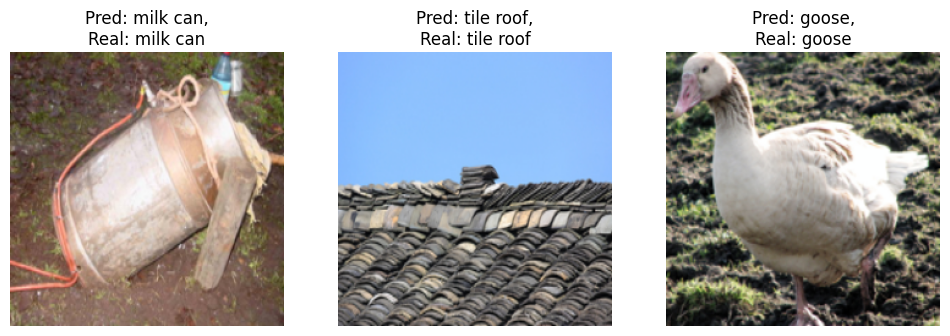

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Get ImageNet-100 class label mapping
imagenet100_label_mapping = dataset["train"].features["label"].int2str

def predict_and_show(images, labels):
    images = images.to(device)  # Move images to GPU if available

    # Run inference
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

    # Convert labels to class names
    predicted_class_names = [imagenet_1000_classes[pred.item()] for pred in predictions]
    true_class_names = [imagenet100_label_mapping(label.item()) for label in labels]

    # Display images with predicted labels
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {predicted_class_names[i]},\nReal: {true_class_names[i]}")
    plt.show()

# Get a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Predict and visualize 3 images
predict_and_show(images[:3], labels[:3])


## Evaluate model

In [ ]:
# Create class mapping from imagenet100 to 1k
imagenet100_to_1k = {
    i: imagenet_1000_classes.index(imagenet100_label_mapping(i).split(",")[0])
    for i in range(100)
}

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([imagenet100_to_1k[i] for i in labels.cpu().numpy()]).to(device)

            # Run model predictions
            outputs = model(images)

            # Compute Top-1 and Top-5 predictions
            _, top1_preds = torch.max(outputs, 1)
            _, top5_preds = torch.topk(outputs, 5, dim=1)

            correct_top1 += (top1_preds == labels).sum().item()
            correct_top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

            total += labels.size(0)

    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total

    print(f"\nTop-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

evaluate_model(model, val_loader, device)


Top-1 Accuracy: 80.70%
Top-5 Accuracy: 95.44%
